In [155]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import movingpandas as mpd
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi

In [15]:
# Load receiver array positions
receivers_gdf = pd.read_csv('../data/VPS-Station-Locations.csv')
receivers_gdf['geometry'] = gpd.points_from_xy(receivers_gdf.Lng, receivers_df.Lat)
receivers_gdf = gpd.GeoDataFrame(receivers_gdf)
receivers_gdf = receivers_gdf.set_crs('EPSG:4326')
receivers_gdf.head()

,Station,Lat,Lng,geometry
0,JWS_Padaro_Inshore_A,34.41342,-119.56553,POINT (-119.56553 34.41342)
1,JWS_Padaro_Inshore_B,34.41036,-119.55805,POINT (-119.55805 34.41036)
2,JWS_Padaro_Inshore_C,34.40792,-119.55454,POINT (-119.55454 34.40792)
3,JWS_Padaro_Inshore_D,34.40330,-119.54847,POINT (-119.54847 34.40330)
4,JWS_Padaro_Inshore_E,34.40070,-119.54592,POINT (-119.54592 34.40070)


In [227]:
# Set the filename
filename = '../data/SharkArray-2020-05-21-thru-05-28.csv'

# Load shark positions data into a GeoDataFrame
shark_gdf = pd.read_csv(filename)
shark_gdf['t'] = pd.to_datetime(shark_gdf['DATETIME'])
shark_gdf['geometry'] = gpd.points_from_xy(shark_gdf.LON, shark_gdf.LAT)
shark_gdf = gpd.GeoDataFrame(shark_gdf)
shark_gdf = shark_gdf.set_crs('EPSG:4326')
shark_gdf = shark_gdf.set_index('t').tz_localize(None)
shark_gdf.head()

,Unnamed: 0,TRANSMITTER,DETECTEDID,DATETIME,X,Y,D,LAT,LON,n,HPE,HPEm,TEMP,DEPTH,ACCEL,DRX,URX,geometry
t,,,,,,,,,,,,,,,,,,
2020-05-21 16:55:00,0,2020-21,A69-9006-7849,5/21/2020 16:55,3430.49,6278.67,-0.607,34.410615,-119.566279,3,3.8,NaN,NaN,-0.6065,NaN,In_A Off_A Off_B OS1,In_A Off_A Off_B OS1,POINT (-119.56628 34.41061)
2020-05-21 19:05:00,1,2020-20,A69-9006-7853,5/21/2020 19:05,4241.98,6283.36,-0.607,34.410658,-119.557453,1,7.5,NaN,NaN,-0.6065,NaN,In_B In_C Off_C,In_B In_C Off_C,POINT (-119.55745 34.41066)
2020-05-21 19:10:00,2,2020-20,A69-9006-7853,5/21/2020 19:10,4322.56,6222.52,-0.607,34.410109,-119.556576,6,3.6,NaN,NaN,-0.6065,NaN,In_B In_C Off_B Off_C OS1,In_B In_C Off_B Off_C OS1,POINT (-119.55658 34.41011)
2020-05-21 19:14:00,3,2020-20,A69-9006-7853,5/21/2020 19:14,4211.33,6306.68,-0.607,34.410868,-119.557786,4,4.1,NaN,NaN,-0.6065,NaN,In_B In_C Off_B Off_C OS1,In_C Off_B Off_C OS1,POINT (-119.55779 34.41087)
2020-05-21 19:32:00,4,2020-20,A69-9006-7853,5/21/2020 19:32,3886.61,6385.11,-0.607,34.411575,-119.561318,4,3.2,NaN,NaN,-0.6065,NaN,In_A In_B Off_A Off_B OS1,In_A In_B Off_A Off_B,POINT (-119.56132 34.41157)


In [228]:
print('The dataset contains', shark_gdf.shape[0], 'rows and', shark_gdf.shape[1], 'columns.')
print('The column names are:', list(shark_gdf.columns.values))
print('The unique transmitter names are:', shark_gdf['TRANSMITTER'].unique())

The dataset contains 9953 rows and 18 columns.
The column names are: ['Unnamed: 0', 'TRANSMITTER', 'DETECTEDID', 'DATETIME', 'X', 'Y', 'D', 'LAT', 'LON', 'n', 'HPE', 'HPEm', 'TEMP', 'DEPTH', 'ACCEL', 'DRX', 'URX', 'geometry']
The unique transmitter names are: ['2020-21' '2020-20' '2020-19' '2020-10' '2020-12' '2020-15' '2020-17'
 '2020-13' '2020-22' '2020-16']


In [229]:
# Create separate trajectories for each shark based on their transmitter ID
traj_collection = mpd.TrajectoryCollection(shark_gdf, 'TRANSMITTER')
print(traj_collection)

TrajectoryCollection with 10 trajectories


In [248]:
for traj in traj_collection:
    print(traj.id.split('_')[0], traj.df.shape[0])

2020-10 1239
2020-12 938
2020-13 1766
2020-15 556
2020-16 617
2020-17 672
2020-19 1519
2020-20 1358
2020-21 744
2020-22 460


In [230]:
# Add a timedelta column which is the time between the previous position and the current position
for traj in traj_collection.trajectories:
    n = traj.df.shape[0]
    timedeltas = [timedelta()] + [traj.df.index[i] - traj.df.index[i - 1] for i in range(1, n)]
    traj.df['TIMEDELTA'] = timedeltas

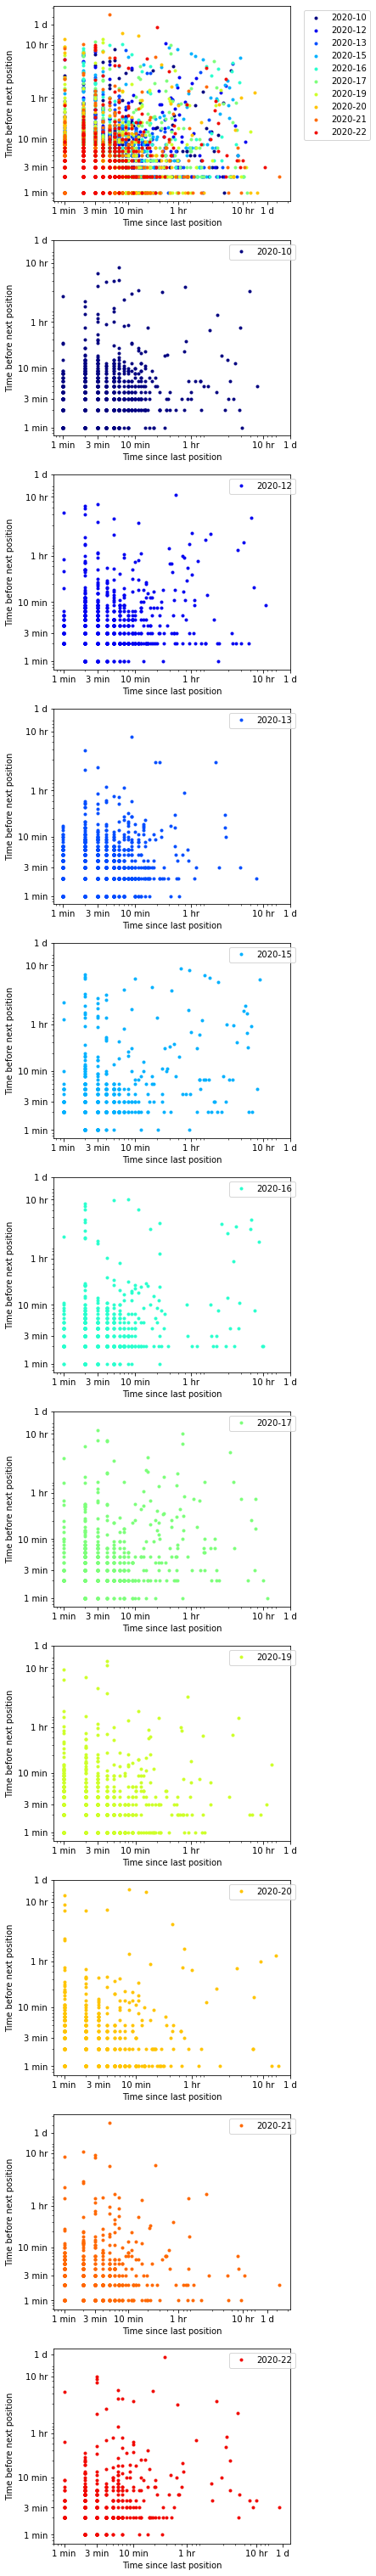

In [505]:
# Plot timemap of positions
cmap = plt.get_cmap('jet')
N = len(traj_collection.trajectories)
fig, axs = plt.subplots(N + 1, 1, figsize=(5, 5 * (N + 1)))
for i, traj in enumerate(traj_collection.trajectories):
    color = cmap(float(i) / N)
    seconds = np.array([traj.df['TIMEDELTA'][i].total_seconds() for i in range(1, traj.df.shape[0])])
    xcoords = seconds[:-1] / 60
    ycoords = seconds[1:] / 60
    axs[0].plot(xcoords, ycoords, marker='.', ls='', markerfacecolor=color, markeredgecolor=color, label=traj.id.split('_')[0])
    axs[i + 1].plot(xcoords, ycoords, marker='.', ls='', markerfacecolor=color, markeredgecolor=color, label=traj.id.split('_')[0])
ticks = [1, 3, 10, 60, 600, 1440]
tick_labels = ['1 min', '3 min', '10 min', '1 hr', '10 hr', '1 d']
for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(bbox_to_anchor=(1.04, 1))
    ax.set_xlabel('Time since last position')
    ax.set_ylabel('Time before next position')
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
plt.show()

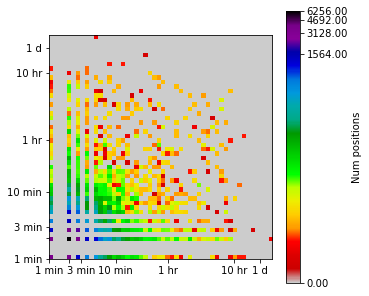

In [507]:
OUTPUT_SCALE = 'log'

# Extract a single trajectory
seconds = []
xcoords = []
ycoords = []
for i, traj in enumerate(traj_collection.trajectories):
    seconds += [traj.df['TIMEDELTA'][i].total_seconds() for i in range(1, traj.df.shape[0])]
    xcoords += seconds[:-1]
    ycoords += seconds[1:]
seconds = np.array(seconds)
xcoords = transform_data(np.array(xcoords))
ycoords = transform_data(np.array(ycoords))

# Set up heatmap
bins = 50
width = 0
H = np.zeros((bins, bins))
max_diff = transform_data(np.max(seconds))
x_heat = (bins - 1) * xcoords / max_diff
y_heat = (bins - 1) * ycoords / max_diff
for i in range(len(xcoords)):
    H[int(x_heat[i]), int(y_heat[i])] += 1
H = ndi.gaussian_filter(H, width)

if OUTPUT_SCALE == 'log':
    # Log scale output
    transform_output = lambda x: np.log10(x + 1)
    transform_output_inv = lambda x: 10 ** x - 1
else:
    # Linear output
    transform_output = lambda x: x
    transform_output_inv = lambda x: x

H = transform_output(H.T)

# Plot
cmap = plt.get_cmap('nipy_spectral_r')
fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(H, origin='lower', extent=(0, max_diff, 0, max_diff), cmap=cmap)
ax.set_xlim(0, max_diff)
ax.set_ylim(0, max_diff)
ticks = transform_data(np.array([1, 2, 3, 10, 60, 600, 1440]) * 60)
tick_labels = ['1 min', '', '3 min', '10 min', '1 hr', '10 hr', '1 d']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
cbar = plt.colorbar()
cbar.set_label('Num positions')

cbar_ticks = transform_output(np.linspace(0, transform_output_inv(np.max(H)), 5))
cbar_tick_labels = ['%.2f' % x for x in transform_output_inv(cbar_ticks)]
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(cbar_tick_labels)

plt.show()